# Introduction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pathlib import Path

In [3]:
import torch
from torch_geometric.utils import to_scipy_sparse_matrix

In [4]:
%run setup_notebooks.py

In [5]:
from src import setup

In [6]:
import logging
logging.getLogger().setLevel(logging.INFO)

In [7]:
%matplotlib inline

---

## Graph plotting routines

In [8]:
def plot_graph(torch_data, perim_data, color='radius', same_aspect_ratio=True, ax=None, markersize=50, 
               cmap_margin=0.0, annotate_nodes = None):
    node_xyz = torch_data.coord.numpy()
    edge_xyz = np.array([
        (torch_data.coord[u].numpy(), torch_data.coord[v].numpy()) for u, v in torch_data.edge_index.T
    ])
    
    if color == 'radius' or color == 'perimeters':
        cbar_name = color
        color = np.array([
            perim_data[color][i] for i in range(node_xyz.shape[0])
        ])
    elif color == 'feature':
        cbar_name = 'feature'
        color = torch_data.x.numpy()
    else:
        raise NotImplementedError
    
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = plt.axes(projection='3d')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
    
    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, color='k', alpha=0.15)

    if cmap_margin is not None:
        vmin = min(color)
        vmax = max(color)
        ptp = np.ptp([vmin, vmax])
        vmin *= 1 - cmap_margin * ptp
        vmax *= 1 + cmap_margin * ptp
    sc = ax.scatter3D(*node_xyz.T, s=markersize, cmap='viridis', c=color, vmin=vmin, vmax=vmax)
    clb = plt.colorbar(sc, shrink=0.7)
    clb.ax.set_title(cbar_name, y=1.1)
    
    # Aspect ratio
    # https://stackoverflow.com/questions/8130823/set-matplotlib-3d-plot-aspect-ratio
    if same_aspect_ratio:
        ax.set_box_aspect(np.ptp(node_xyz, axis=0))
        
    if annotate_nodes is not None:
        if annotate_nodes == True:
            annotate_nodes = map(str, range(node_xyz.shape[0]))
            
        for i, (x, y, z) in enumerate(node_xyz):
            ax.text(x, y, z, annotate_nodes[i])
    #if interactive_mode:
    #    annot = ax.annotate("", xy=(-2,26), xytext=(20,20),textcoords="offset points",
    #                bbox=dict(boxstyle="round", fc="w"),
    #                arrowprops=dict(arrowstyle="->"))
    #    #annot.set_visible(False)
    #    names = [str(i) for i in range(node_xyz.shape[0])]
    #    print(names)
    #    fig.canvas.mpl_connect("motion_notify_event", lambda event: hover(event, annot, ax, fig, sc, names))

In [9]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    """https://stackoverflow.com/questions/47617952/drawing-a-righthand-coordinate-system-in-mplot3d"""
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)
    
    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

def draw_arrows_xyz(location, ax, arrow_length):
    arrow_prop_dict = dict(mutation_scale=20, arrowstyle='->', shrinkA=0, shrinkB=0)
    
    location = np.array(location)
    start_location = np.array([
        location, location, location
    ])
    end_location = start_location + np.array([
        [arrow_length, 0, 0], [0, arrow_length, 0], [0, 0, arrow_length]
    ])
    
    for start, end, axis in zip(start_location, end_location, 'xyz'):
        xs, ys, zs = zip(start, end)
        a = Arrow3D(xs, ys, zs, **arrow_prop_dict, color='r')
        ax.add_artist(a)
        
        ax.text(*end, f'$\mathbf {axis}$', fontsize=18)

## Graph manipulation routines

In [10]:
from torch_geometric.utils import subgraph as torch_subgraph
from typing import Iterable

def subgraph(data, keep_nodes, map_nodes=None):
    def perform_mapping(nodes, mapping):
        assert set(keep_nodes).issuperset(nodes)
        mapped_nodes = [mapping[u] for u in nodes]
        return mapped_nodes
    
    keep_nodes = list(map(int, keep_nodes))
    out = data.clone()
    if 'x' in out:
        out.x = data.x[keep_nodes]
    out.edge_index = torch_subgraph(keep_nodes, out.edge_index, relabel_nodes=True)[0]
    out.coord = out.coord[keep_nodes]
    
    if 'num_nodes' in data:
        out.num_nodes = out.coord.shape[0]
    
    mapping = {
        u: i
        for i, u in enumerate(keep_nodes)
    }
    
    if map_nodes is not None:
        map_nodes = list(map_nodes)
        if isinstance(map_nodes[0], Iterable):
            mapped_nodes = [
                perform_mapping(nodes, mapping)
                for nodes in map_nodes
            ]
        else:
            mapped_nodes = perform_mapping(map_nodes, mapping)
        
        # Check nodes to map are in the kept nodes
        #assert set(keep_nodes).issuperset(map_nodes)
        
        #mapped_nodes = [mapping[u] for u in map_nodes]
        return out, mapped_nodes
    
    return out

In [11]:
from copy import deepcopy
from torch_geometric.utils import k_hop_subgraph

def plot_subgraph_for_perim(torch_data, perim_data, node_along_path=0, khops=5, metric='radius', **kwargs):
    perim_data = deepcopy(perim_data)
    # Map the node_along_path to its actual node value
    node_along_path = perim_data['cutting_path'][node_along_path]
    # Find the corresponding annulus
    target_annulus = [
        p[:-1]
        for p, l in perim_data['shortest_paths']
        if p[0] == node_along_path
    ]
    assert len(target_annulus) == 1
    target_annulus = target_annulus[0]
    
    # Subgraph
    sub_nodes, sub_edge_index, central_node, _ = k_hop_subgraph(target_annulus, khops, torch_data.edge_index)
    
    # Prepare mapping of perim data
    sub_nodes_set = set(sub_nodes.tolist())
    tmp = [
        (node, perim)
        for node, perim in perim_data[metric].items()
        if node in sub_nodes_set
    ]
    nodes, perims = zip(*tmp)
    
    # Extract subgraph
    data_sub, mapped_nodes = subgraph(torch_data, sub_nodes, map_nodes=nodes)
    
    # Map perimeter nodes
    perim_data[metric] = dict(zip(mapped_nodes, perims))
    
    if 'color' in kwargs:
        plot_graph(data_sub, perim_data, **kwargs)
    else:
        plot_graph(data_sub, perim_data, color=metric, **kwargs)

---

## Routines for perimeter data

In [12]:
def add_radius(perim_data):
    perim_data['radius'] = {
        k: v / (np.pi * 2)
        for k, v in perim_data['perimeters'].items()
    }

def read_data(file_name, path_perim, path_torch, radius: bool = True):
    file = Path(file_name).stem
    perim_data = parse_perimeter_data(path_perim.joinpath(file + '.json'))
    torch_data = torch.load(path_torch.joinpath(file + '.pt'))
    
    if radius:
        add_radius(perim_data)
    
    return perim_data, torch_data

In [13]:
def get_along_path(perim_data, metric='radius'):
    return np.array([
        perim_data[metric][u]
        for u in perim_data['cutting_path']
    ])

# Example on 1 sample

In [14]:
from src.perimeter import parse_perimeter_data

In [15]:
path_perim = setup.get_dataset_path('perimeters')
path_torch = setup.get_dataset_path('CoordToCnc')

2022-05-23 10:09:20,816 [setup] [INFO] get_data_path(): using user-defined data path
2022-05-23 10:09:20,820 [setup] [INFO] get_data_path(): using user-defined data path


In [16]:
# Pick any sample
file_perim = next(path_perim.glob('*.json'))
perim_data, torch_data = read_data(file_perim, path_perim, path_torch)

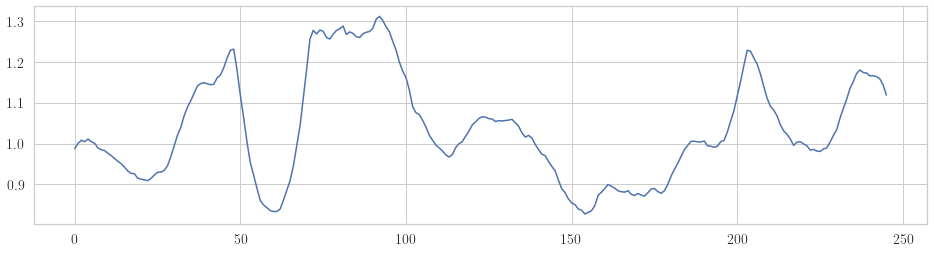

In [17]:
radius_along_path = get_along_path(perim_data)
plt.figure(figsize=(16, 4))
plt.plot(range(len(radius_along_path)), radius_along_path);

Let us check the graph around 30th node along the path:

In [18]:
%matplotlib widget

/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


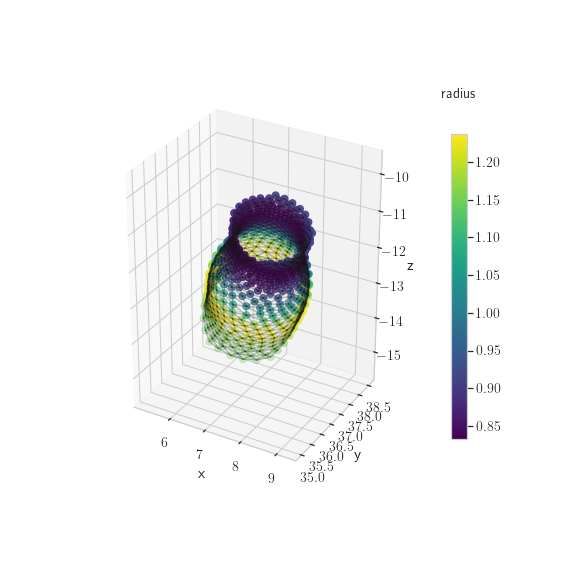

In [19]:
plot_subgraph_for_perim(torch_data, perim_data, node_along_path=50, khops=10)

### Radius variation

In [20]:
from scipy.signal import convolve

def compute_radius_variation(perim_data, kernel_size=3):
    radius_along_path = get_along_path(perim_data)
    
    assert kernel_size % 2 == 1
    padsize = kernel_size // 2
    kernel = np.pad(np.array([0]), (padsize, ), constant_values=(-1, 1))
    
    diffs = convolve(radius_along_path, kernel, mode='same') / padsize
    diffs[:padsize] = np.nan
    diffs[-padsize:] = np.nan
    return diffs

In [21]:
%matplotlib inline

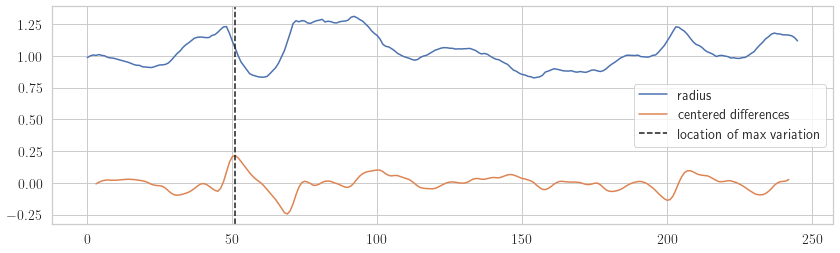

In [22]:
plt.figure(figsize=(14, 4))
diff = compute_radius_variation(perim_data, kernel_size=7)
r = get_along_path(perim_data)
plt.plot(range(len(r)), r, label='radius')
plt.plot(range(len(diff)), diff, label='centered differences')
i = np.nanargmax(diff)
plt.axvline(i, color='k', ls='--', label='location of max variation')
plt.legend();

# Dataset analysis

In [23]:
files = list(map(lambda p: p.stem, path_torch.glob('*pt')))

perim_data, torch_data = zip(*[read_data(file, path_perim, path_torch) for file in files])

## Find fastest artery narrowing

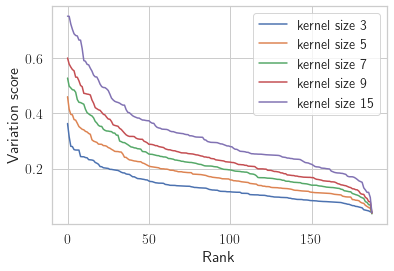

In [24]:
ranking = dict()
for kernel_size in (3, 5, 7, 9, 15):
    convolutions = [
        compute_radius_variation(p, kernel_size)
        for p in perim_data
    ]

    # Find maximum in each signal
    maxima = np.array([
        np.nanmax(conv) for conv in convolutions
    ])

    # Rank them
    ranked = np.argsort(maxima)[::-1]
    ranking[kernel_size] = ranked

    # Plot
    plt.plot(range(len(maxima)), maxima[ranked], label=f'kernel size {kernel_size}')
    
plt.xlabel('Rank')
plt.ylabel('Variation score')
plt.legend();

In [25]:
[
    np.sort(r[:10]) for r in ranking.values()
]

[array([ 33,  49, 106, 112, 140, 149, 168, 176, 177, 180]),
 array([ 23,  33, 106, 112, 137, 140, 168, 176, 177, 180]),
 array([ 23,  33,  62, 106, 112, 140, 168, 176, 177, 180]),
 array([ 33,  62, 106, 112, 137, 140, 168, 176, 177, 180]),
 array([ 33,  62, 106, 112, 137, 140, 171, 176, 177, 180])]

The selected graphs of fastest narrowing are similar no matter the kernel size. 

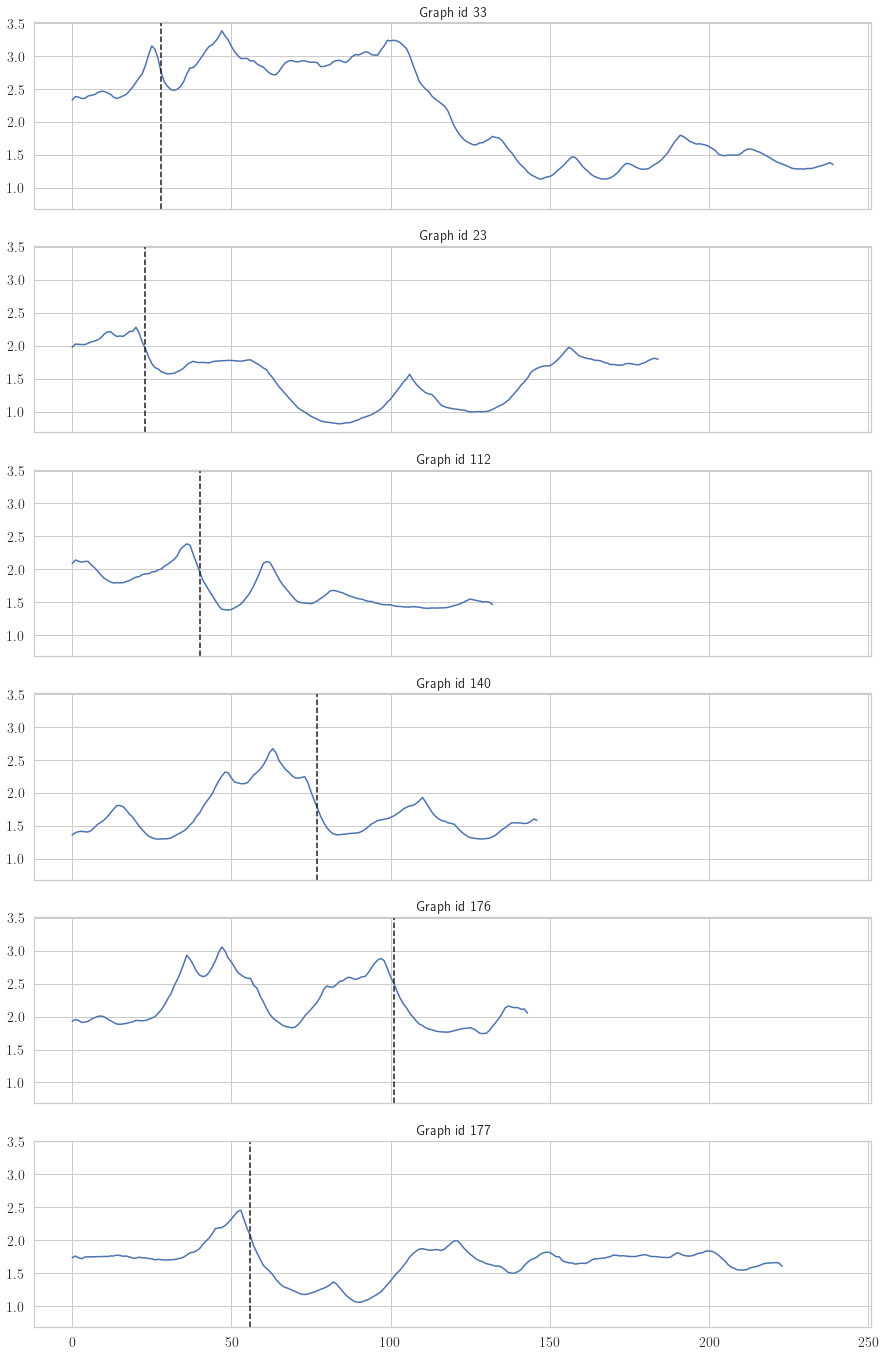

In [26]:
graph_ids = [33, 23, 112, 140, 176, 177]
_, ax = plt.subplots(len(graph_ids), 1, figsize=(15, len(graph_ids)*4), sharex=True, sharey=True)

for a, i in zip(ax, graph_ids):
    data = perim_data[i]
    radius = get_along_path(data)
    conv = compute_radius_variation(data, kernel_size=9)
    argmax = np.nanargmax(conv)
    a.plot(range(len(radius)), radius)
    a.axvline(argmax, ls='--', color='k')
    a.set_title(f'Graph id {i}')

In [27]:
%matplotlib widget

/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  if sys.path[0] == '':


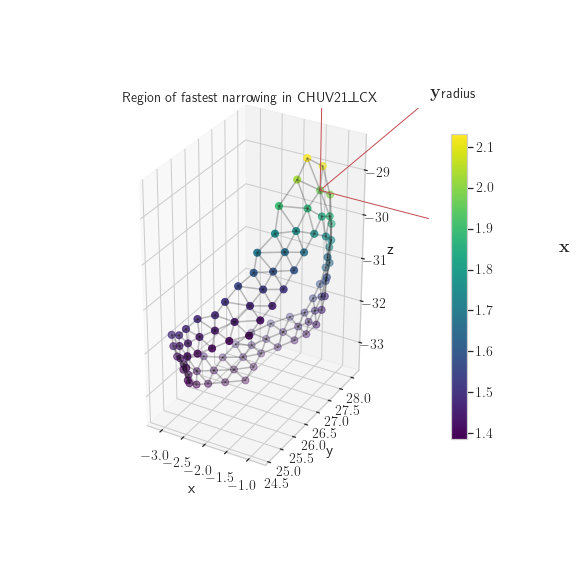

In [35]:
gid = 112

conv = compute_radius_variation(perim_data[gid], kernel_size=9)
node_along_path = np.nanargmax(conv)

plot_subgraph_for_perim(torch_data[gid], perim_data[gid], node_along_path=node_along_path, khops=1)

node = perim_data[gid]['cutting_path'][node_along_path]
draw_arrows_xyz(torch_data[gid].coord[node], plt.gca(), 5)

plt.title(f'Region of fastest narrowing in {files[gid]}');

In [217]:
process_figure(f'figs/narrowing_{files[gid]}.pdf')

/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  if sys.path[0] == '':


## Choose lengthscale for Laplacian exponential

In [264]:
from torch_geometric.utils import to_scipy_sparse_matrix

In [261]:
from src.graph_linalg import get_laplacian, matrix_exponentials

In [260]:
from src.data_augmentation import create_sample_graph_features, add_edge_weights

In [232]:
path_torch_perim = setup.get_dataset_path('CoordToCnc_perimeters')

2022-05-19 21:07:52,827 [setup] [INFO] get_data_path(): using user-defined data path


In [376]:
gid = 112

perim_sample, torch_sample = read_data(files[gid], path_perim, path_torch_perim)
torch_sample = add_edge_weights(torch_sample, inverse=True)

L = get_laplacian(to_scipy_sparse_matrix(torch_sample.edge_index, edge_attr=torch_sample.edge_weight))

In [443]:
tau0 = 9
E = next(matrix_exponentials(L, tau0, 1))

In [378]:
def format_sample_for_analysis(torch_sample, node, Lexp):
    out = torch_sample.clone()
    out.x = torch.from_numpy(Lexp[:, node].reshape(-1, 1))
    return out

In [379]:
%matplotlib widget

/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  if sys.path[0] == '':
/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  if sys.path[0] == '':


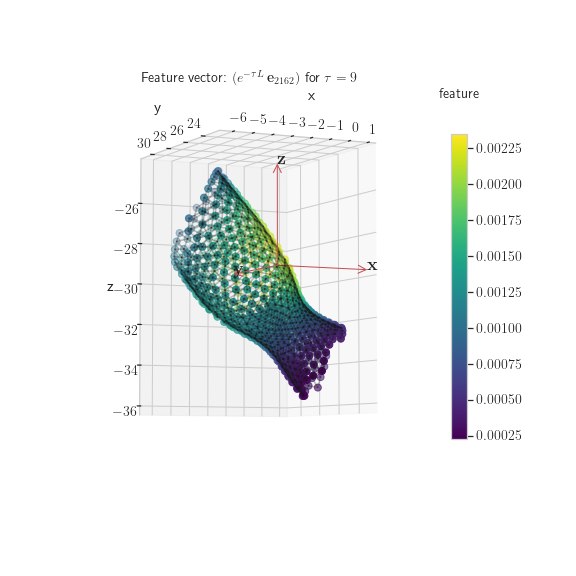

In [444]:
node = perim_sample['cutting_path'][node_along_path]
s = format_sample_for_analysis(torch_sample, node, E)
plot_subgraph_for_perim(s, perim_sample, node_along_path=node_along_path, khops=10, color='feature')
draw_arrows_xyz(torch_sample.coord[node], plt.gca(), 5)
plt.gca().view_init(25.9677, -54.4556)
plt.gca().view_init(-5.28229999999985, -115.94753548387075)
plt.title(r'Feature vector: $(e^{-\tau L} \,\mathbf e_{'+str(node)+r'})$ for $\tau = '+str(tau0)+'$');

In [437]:
plt.gca().elev, plt.gca().azim

(-5.28229999999985, -115.94753548387075)

In [445]:
process_figure(f'figs/lapl_exp_tau0-{tau0}_opposite_side.pdf')

/home/maousi/miniconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  if sys.path[0] == '':


---

# Analyze resulting features

In [18]:
path = setup.get_dataset_path('graph_features').joinpath('perimeters.pt')
feat = torch.load(path)

2022-05-21 11:22:22,357 [setup] [INFO] get_data_path(): using user-defined data path


In [20]:
feat.keys()

dict_keys(['input_dset', 'taus', 'features'])

In [21]:
feat['input_dset'], feat['taus']

('CoordToCnc_perimeters', [1, 3, 5, 9])

In [27]:
df = pd.DataFrame(map(lambda e: e.numpy().flatten(), feat['features'].values()), feat['features'].keys())
df.columns = [f'q{i}' for i in range(len(df.columns))]
df

,q0,q1,q2,q3,q4
CHUV01_LAD,0.078534,0.037409,0.019725,0.012550,0.006512
CHUV01_LCX,0.121129,0.039351,0.012399,0.006619,0.003674
CHUV02_LAD,0.093143,0.048238,0.028188,0.020726,0.014453
CHUV02_LCX,0.063946,0.026713,0.015274,0.010873,0.007119
CHUV02_RCA,0.130449,0.060683,0.037924,0.028581,0.019219
...,...,...,...,...,...
OLV032_LAD,0.106124,0.056838,0.036598,0.027036,0.017403
OLV032_LCX,0.070745,0.033421,0.017359,0.010458,0.004650
OLV032_RCA,0.082438,0.033392,0.016126,0.010149,0.005458
OLV034_LAD,0.079282,0.033751,0.020371,0.014724,0.008752


In [31]:
df_labels = setup.get_data_paths()[0].joinpath('CFD/labels/WSSdescriptors_AvgValues.xlsx')
df = df.join(pd.read_excel(df_labels).set_index('Code').FC)

2022-05-21 11:29:07,494 [setup] [INFO] get_data_path(): using user-defined data path


In [32]:
df

,q0,q1,q2,q3,q4,FC
CHUV01_LAD,0.078534,0.037409,0.019725,0.012550,0.006512,0
CHUV01_LCX,0.121129,0.039351,0.012399,0.006619,0.003674,1
CHUV02_LAD,0.093143,0.048238,0.028188,0.020726,0.014453,1
CHUV02_LCX,0.063946,0.026713,0.015274,0.010873,0.007119,0
CHUV02_RCA,0.130449,0.060683,0.037924,0.028581,0.019219,0
...,...,...,...,...,...,...
OLV032_LAD,0.106124,0.056838,0.036598,0.027036,0.017403,1
OLV032_LCX,0.070745,0.033421,0.017359,0.010458,0.004650,0
OLV032_RCA,0.082438,0.033392,0.016126,0.010149,0.005458,0
OLV034_LAD,0.079282,0.033751,0.020371,0.014724,0.008752,0


In [40]:
df.describe()

,q0,q1,q2,q3,q4,FC
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000
mean,0.099502,0.045947,0.026796,0.019322,0.012586,0.425532
std,0.062417,0.035276,0.022012,0.016387,0.010907,0.495744
min,0.020659,0.005500,0.003277,0.002424,0.001298,0.000000
25%,0.056759,0.023932,0.013176,0.009525,0.005735,0.000000
50%,0.081444,0.033111,0.019269,0.013996,0.009183,0.000000
75%,0.130559,0.059237,0.035506,0.024514,0.015850,1.000000
max,0.354938,0.205601,0.132326,0.101190,0.071189,1.000000


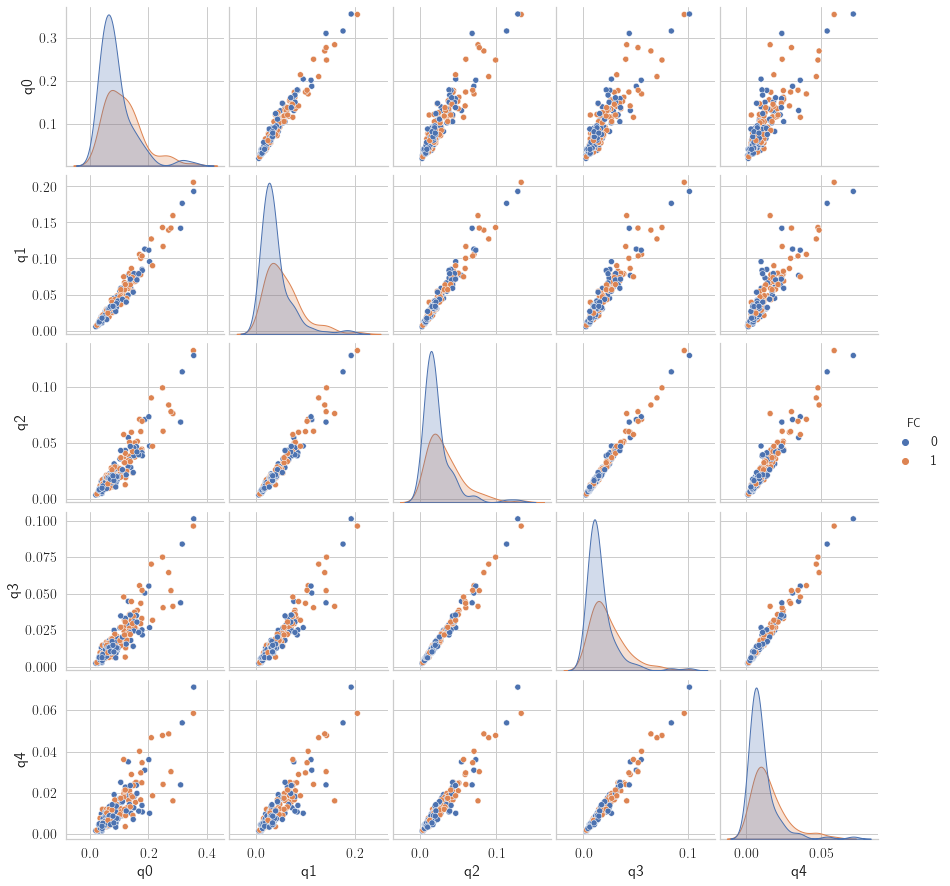

In [34]:
sns.pairplot(data=df, hue='FC')

In [36]:
df_test = df.copy()
for c in df_test.columns:
    df_test[c+'_sq'] = df[c]**2

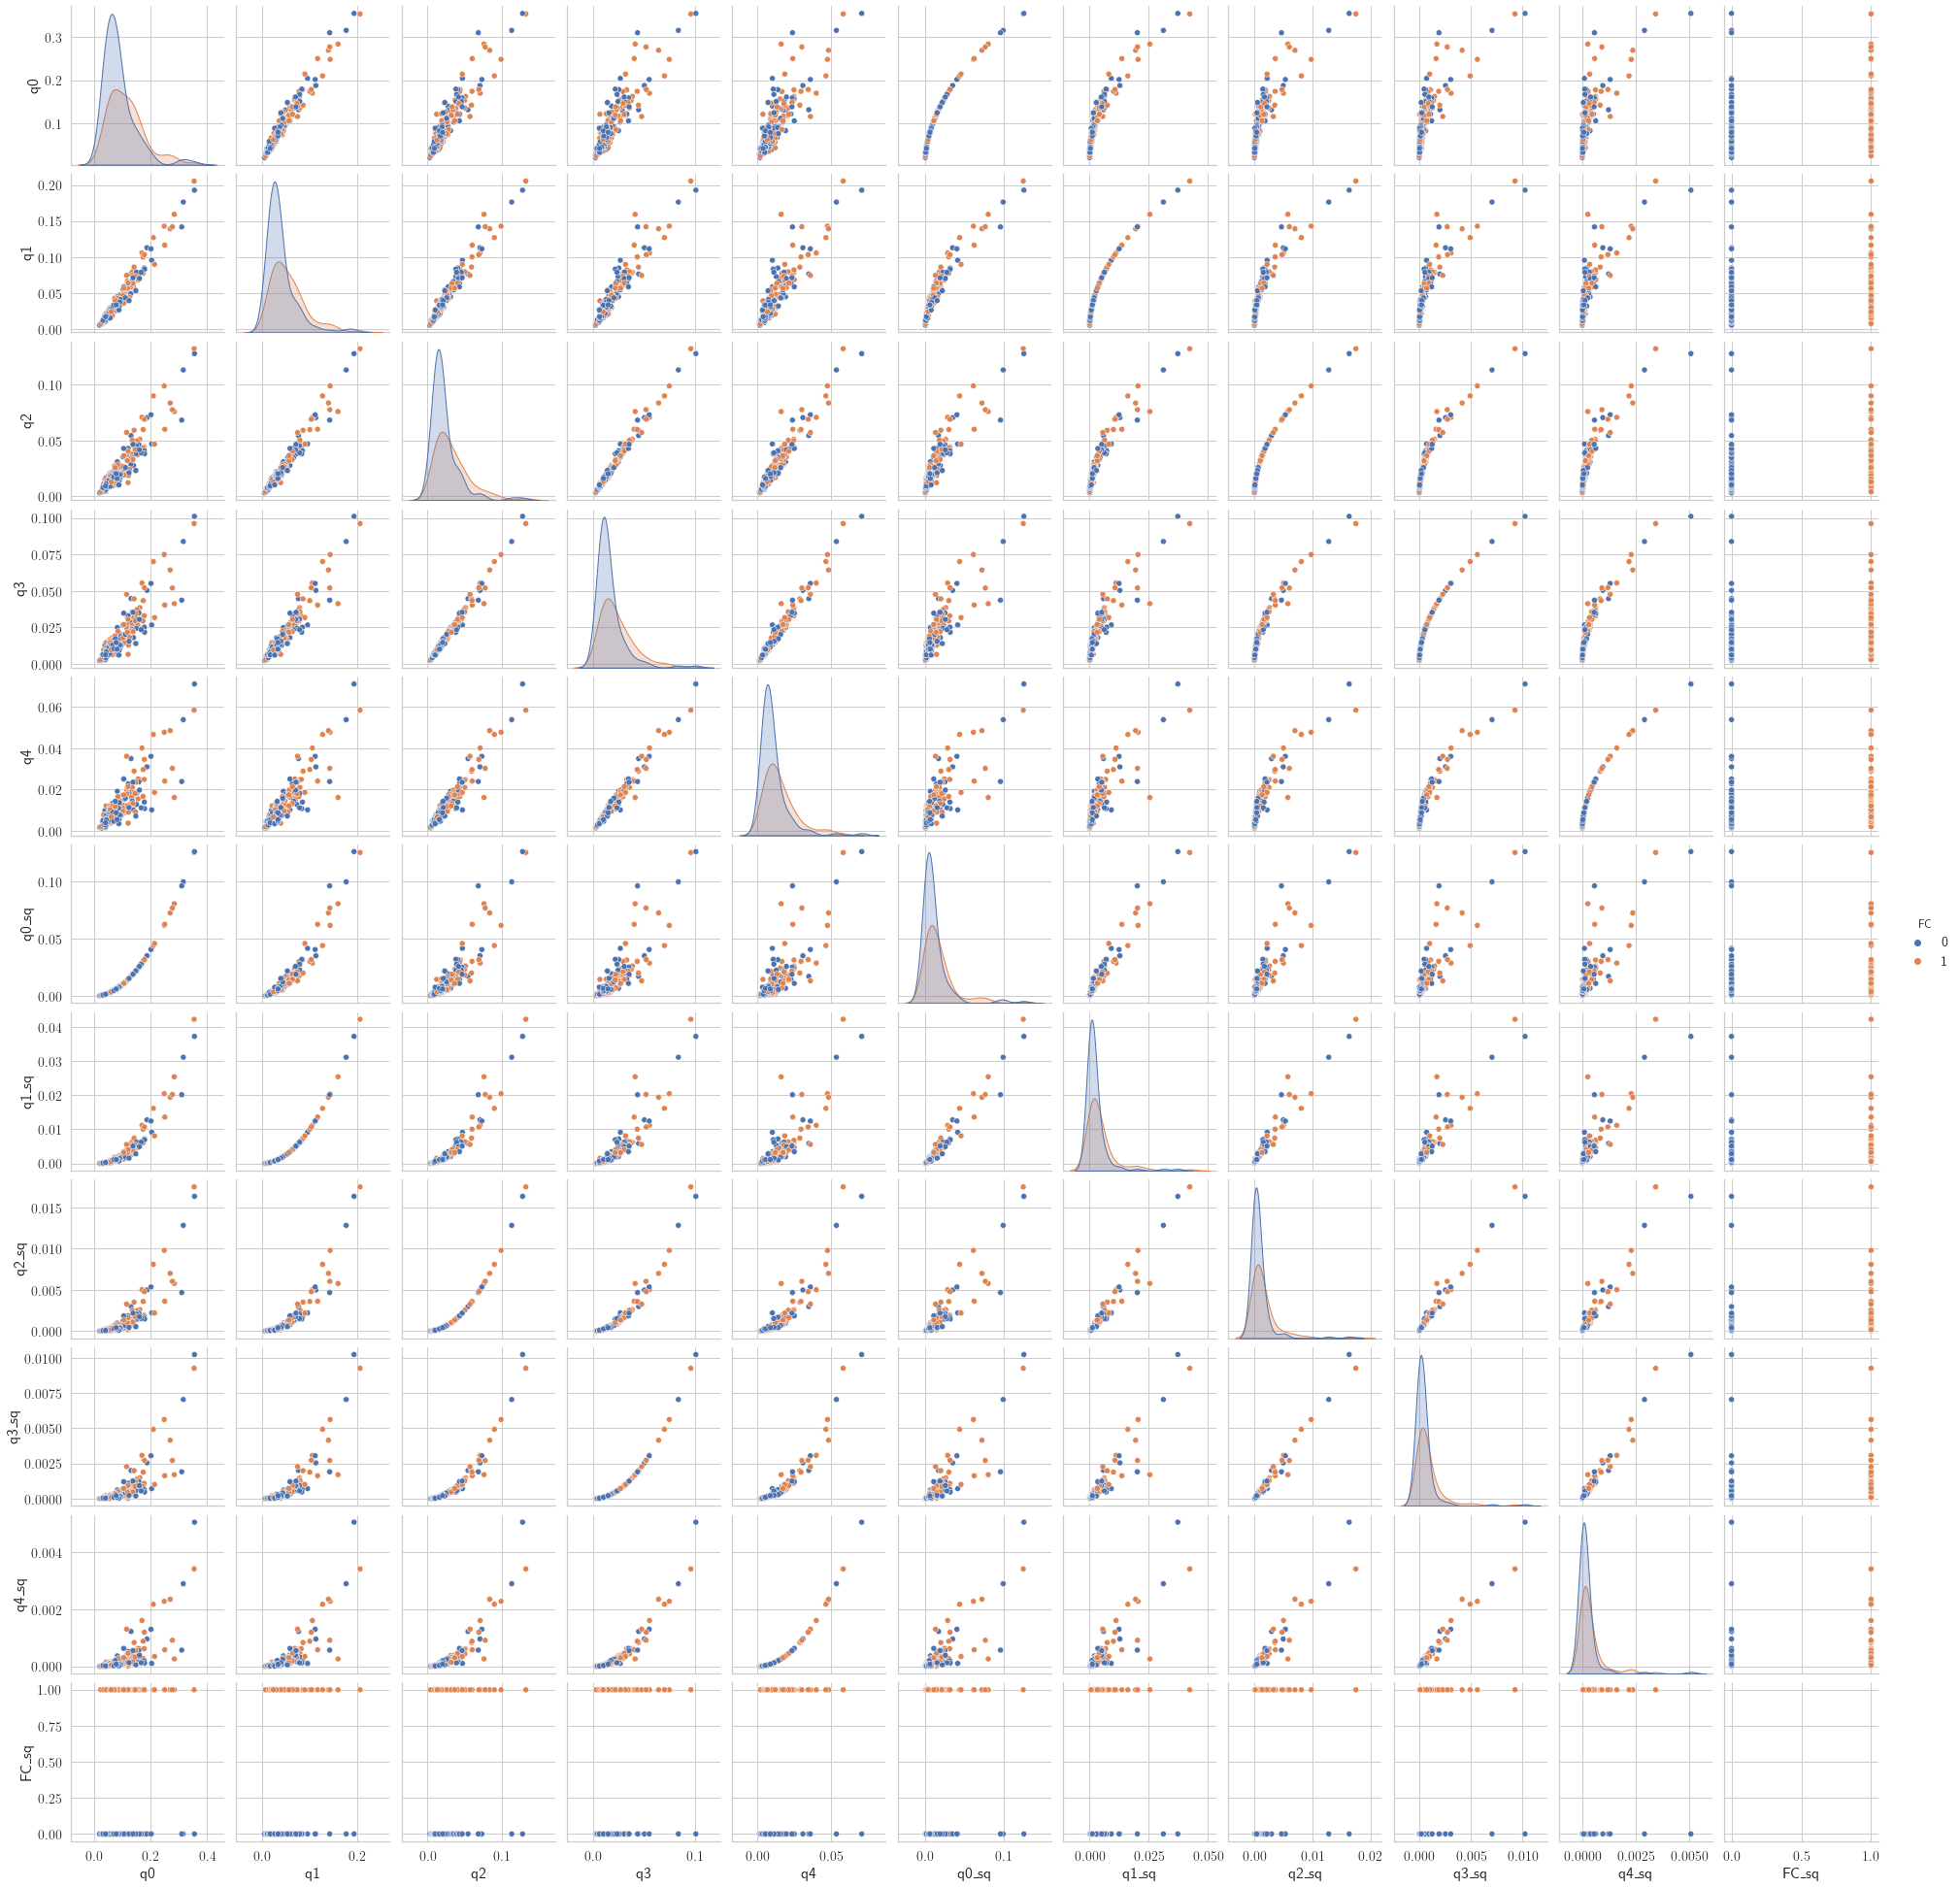

In [37]:
sns.pairplot(data=df_test, hue='FC')

In [46]:
from sklearn.decomposition import PCA

In [73]:
X = df.drop(columns='FC').values
# Standardize
X = (X - X.mean(axis=0)) / X.std(axis=0)

pca = PCA(2).fit(X)
comp = pca.transform(X)

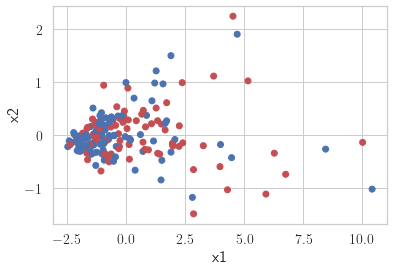

In [76]:
plt.scatter(comp[:, 0], comp[:, 1], color=df.FC.replace({0: 'b', 1: 'r'}))
plt.xlabel('x1')
plt.ylabel('x2');

In [67]:
pca.components_

array([[ 0.43067893,  0.44763139,  0.45310905,  0.44904573,  0.43483333,
         0.13458049],
       [ 0.06376514,  0.05629494,  0.06049763,  0.06199326,  0.05850814,
        -0.99087767]])

---